In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import random
from parking_context_recognizer.models import model_mobilenetv2 as model

In [3]:
from parking_slot_detector.config import *
from parking_slot_detector.utils.data_utils import get_batch_data, parse_line
from parking_slot_detector.utils.misc_utils import parse_anchors, read_class_names, AverageMeter
import cv2
import numpy as np

from parking_slot_detector.utils.eval_utils import get_preds_gpu

from parking_slot_detector.utils.eval_utils import (
    evaluate_on_gpu,
    get_preds_gpu,
    parse_gt_rec,
    parse_gt_quadrangle,
    calc_park_score,
    park_eval,
    eval_result_file,
)
from parking_slot_detector.utils.nms_utils import gpu_nms
from parking_slot_detector.utils.plot_utils import plot_one_box, plot_one_quad
from parking_slot_detector.model import yolov3



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
image_dir = "parking_slot_detector/data/bird_1.jpg"
image = cv2.imread(image_dir, cv2.COLOR_RGB2GRAY)
img = cv2.resize(image, (64, 192))
image = image[np.newaxis,:]
img = img[np.newaxis, :]

In [5]:
model_input = (192,64,3) 
test_model = model(model_input)
test_model.load_weights("weight_pcr/trained/trained.ckpt")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\limaries30\.conda\envs\tensor_flow\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [6]:
img = tf.image.per_image_standardization(img)
predicted_result = test_model.predict(img,steps=1)

type_predict, angle_predict = predicted_result[0], predicted_result[1]

tf.keras.backend.clear_session()

type_predict = np.argmax(type_predict, axis=1)


angle_predict = angle_predict * 180.0 - 90.0

print(type_predict,angle_predict)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
[0] [[1.1780243]]


In [7]:
angle_predict[0][0]

1.1780243

In [8]:
anchors = parse_anchors("parking_slot_detector/data/anchors.txt")
weight_path="weight_psd/fine_tuned_type_0"
class_num = 2

image = tf.to_float(image/255)
#image = tf.image.per_image_standardization(image)

# setting placeholders
is_training = tf.placeholder(dtype=tf.bool, name="phase_train")
handle_flag = tf.placeholder(tf.string, [], name="iterator_handle_flag")
# pred_boxes_flag = tf.placeholder(tf.float32, [1, None, None])
pred_scores_flag = tf.placeholder(tf.float32, [1, None, None])
pred_quads_flag = tf.placeholder(tf.float32, [1, None, None])

gpu_nms_op = gpu_nms(
    pred_quads_flag,
    pred_scores_flag,
    class_num,
    NMS_TOPK,
    THRESHOLD_OBJ,
    THRESHOLD_NMS,
    apply_rotate=True,
)

anchor_path parking_slot_detector/data/anchors.txt
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
yolo_model = yolov3(class_num, anchors)
with tf.variable_scope("yolov3"):
    pred_feature_maps = yolo_model.forward(image, is_training=is_training)


image_angle = tf.dtypes.cast([angle_predict[0][0]], tf.float32)

y_pred = yolo_model.predict(pred_feature_maps, image_angle)

saver_to_restore = tf.train.Saver()
print("weight_path", weight_path)
weight_file = tf.train.latest_checkpoint(weight_path)  # ../weight_psd/fine_tuned_type_0

vars_in_checkpoint = tf.train.list_variables(weight_path)
with tf.Session() as sess:
    sess.run([tf.global_variables_initializer()])
    saver_to_restore.restore(sess, weight_file)

    # start_time = time.time()
    __y_pred = sess.run([y_pred], feed_dict={is_training: False})
    print('__y_pred',__y_pred)
    pred_content = get_preds_gpu(
        sess, gpu_nms_op, pred_quads_flag, pred_scores_flag, [0], __y_pred
    )

    for img_id, x_min, y_min, x_max, y_max, score, label, quad in pred_content:
        print(
            "label: %d score: %.8f %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f "
            % (
                label,
                score,
                quad[0],
                quad[1],
                quad[2],
                quad[3],
                quad[4],
                quad[5],
                quad[6],
                quad[7],
            )
        )



weight_path weight_psd/fine_tuned_type_0
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from weight_psd/fine_tuned_type_0\trained_type_0
__y_pred [(array([[[0.00012347],
        [0.00067624],
        [0.00356624],
        ...,
        [0.00263175],
        [0.00683349],
        [0.00129467]]], dtype=float32), array([[[6.4074993e-06, 8.5929829e-01],
        [1.1186004e-03, 1.8856511e-01],
        [6.4456463e-04, 7.5740099e-01],
        ...,
        [9.9556327e-01, 9.0774894e-04],
        [9.9944943e-01, 3.9839745e-04],
        [9.8780924e-01, 4.3144524e-03]]], dtype=float32), array([[[ -46.081013,   85.02619 ,  233.80151 , ...,  -94.93651 ,
         -231.52608 , -215.10303 ],
        [ 197.72511 ,  403.05835 ,  157.76167 , ...,  107.87479 ,
          103.01177 ,  171.51738 ],
        [ 534.79724 ,  -83.72693 ,  521.3196  , ...,  213.05582 ,
          527.2435  ,  213.88043 ],
        ...,
        [ 212.47493 

In [10]:
img = image.eval(session=tf.compat.v1.Session()).squeeze()

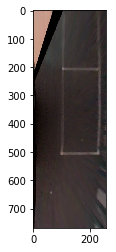

In [11]:
plt.imshow(img)

In [21]:
test_image = cv2.imread(image_dir, cv2.COLOR_RGB2GRAY)

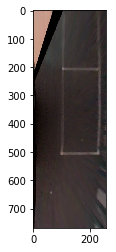

In [13]:
plt.imshow(test_image)

In [14]:
def plot_one_quad(img, quad, label=None, color=None, line_thickness=None):
    '''
    coord: [x_min, y_min, x_max, y_max] format coordinates.
    img: img to plot on.
    label: str. The label name.
    color: int. color index.
    line_thickness: int. rectangle line thickness.
    '''
    tl = line_thickness or int(round(0.002 * max(img.shape[0:2])))  # line thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2, c3, c4 = (int(quad[0]), int(quad[1])), (int(quad[2]), int(quad[3])), (int(quad[4]), int(quad[5])), (int(quad[6]), int(quad[7]))
    pts = np.array([quad[0:2], quad[2:4], quad[4:6], quad[6:8], quad[0:2]], np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(img, [pts], False, color, thickness=tl)
    if label:
        tf = max(tl - 1, 2)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=float(tl) / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        # cv2.rectangle(img, c1, c2, color, -1)  # filled
        cv2.putText(img, label, ((c1[0]+c3[0]-t_size[0])//2, (c1[1]+c3[1]+t_size[1])//2), 0, float(tl) / 3, color, thickness=tf, lineType=cv2.LINE_AA)

        
def plot_one_box(img, coord, label=None, color=None, line_thickness=None):
    '''
    coord: [x_min, y_min, x_max, y_max] format coordinates.
    img: img to plot on.
    label: str. The label name.
    color: int. color index.
    line_thickness: int. rectangle line thickness.
    '''
    tl = line_thickness or int(round(0.002 * max(img.shape[0:2])))  # line thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(coord[0]), int(coord[1])), (int(coord[2]), int(coord[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=float(tl) / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, float(tl) / 3, [0, 0, 0], thickness=tf, lineType=cv2.LINE_AA)

In [15]:
pred_content

[[0,
  98.46199,
  205.6199,
  237.0567,
  507.94922,
  0.9203794,
  0,
  array([108.20889, 205.6199 ,  98.46199, 504.9096 , 225.66238, 507.94922,
         237.0567 , 208.45122], dtype=float32)]]

In [16]:
#plot_one_box(test_image,pred_content[0][-1])

In [17]:
plot_one_quad(test_image,pred_content[0][-1])

In [22]:
cv2.imshow('img',test_image)
cv2.waitKey(0)

-1

In [19]:
pred_content

[[0,
  98.46199,
  205.6199,
  237.0567,
  507.94922,
  0.9203794,
  0,
  array([108.20889, 205.6199 ,  98.46199, 504.9096 , 225.66238, 507.94922,
         237.0567 , 208.45122], dtype=float32)]]

In [20]:
#tf.reset_default_graph()